In [50]:
import numpy as np
def rbf_kernel(x1, x2, l=1.0, sigma_f=1.0): #need to cite this
    """
    Isotropic squared exponential kernel. Computes
    a covariance matrix from points in x1 and x2.
        
    Args:
        x1: Array of m points (m x d).
        x2: Array of n points (n x d).
        l: Length scale.
        sigma_f: Signal variance.
            
    Returns:
        Covariance matrix (m x n).
    """
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-0.5 *sqdist / l**2) 

def upper_confidence_bound(mean, variance, kappa=2):
    return mean.flatten() + kappa * np.sqrt(np.diag(variance))

def posterior_update(X,Y, X_new):
    K = rbf_kernel(X, X) + (std**2)*np.eye(len(X)) # note that this is just the kernel plus the noise to make posterior equations below cleaner, also potential hyperparameter since we won't know the exact noise
    K_s = rbf_kernel(X, X_new)
    K_ss = rbf_kernel(X_new, X_new)
    posterior_mean = K_s.T.dot(np.linalg.inv(K)).dot(Y)
    posterior_cov = K_ss - K_s.T.dot(np.linalg.inv(K)).dot(K_s)
    return posterior_mean, posterior_cov

def call_function(x, noise= 0.05):
    return np.sin(x) + np.random.normal(0, noise)

def initialize_query(n=10,d=100):
    X = np.random.uniform(-3, 3, size=(n, 1))  
    Y = call_function(X)
    domain = np.linspace(-5, 5, d).reshape(-1, 1)
    return X,Y, domain
                               

# Toy Dataset

std = 0.05 
                               
np.random.seed(42)
X = np.random.uniform(-3, 3, size=(10, 1)) #initial query
Y = np.sin(X)   #true function 

X_new = np.linspace(-5, 5, 100).reshape(-1, 1) # This just for the regression to view the actual GP

#Calculating covariances
K = rbf_kernel(X, X) + (std**2)*np.eye(len(X)) # note that this is just the kernel plus the noise to make posterior equations below cleaner, also potential hyperparameter since we won't know the exact noise
K_s = rbf_kernel(X, X_new)
K_ss = rbf_kernel(X_new, X_new)

#Posterior Update
posterior_mean = K_s.T.dot(np.linalg.inv(K)).dot(Y)
posterior_cov = K_ss - K_s.T.dot(np.linalg.inv(K)).dot(K_s)


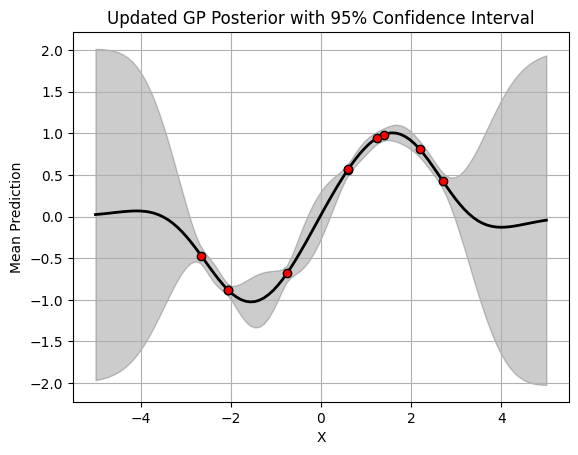

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(X_new, posterior_mean, 'k', lw=2, zorder=9)
plt.fill_between(X_new.flatten(), posterior_mean.flatten() - 2 * np.sqrt(np.diag(posterior_cov)), posterior_mean.flatten() + 2 * np.sqrt(np.diag(posterior_cov)), alpha=0.2, color='k')
plt.scatter(X, Y, c='r', zorder=10, edgecolors=(0, 0, 0))
plt.title("Updated GP Posterior with 95% Confidence Interval")
plt.xlabel("X")
plt.ylabel("Mean Prediction")
plt.grid(True)
plt.show()

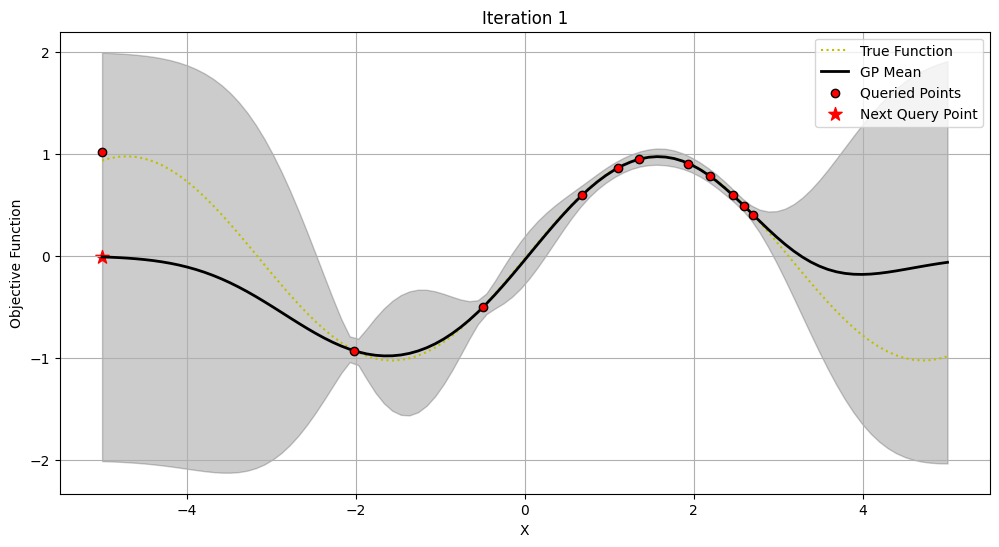

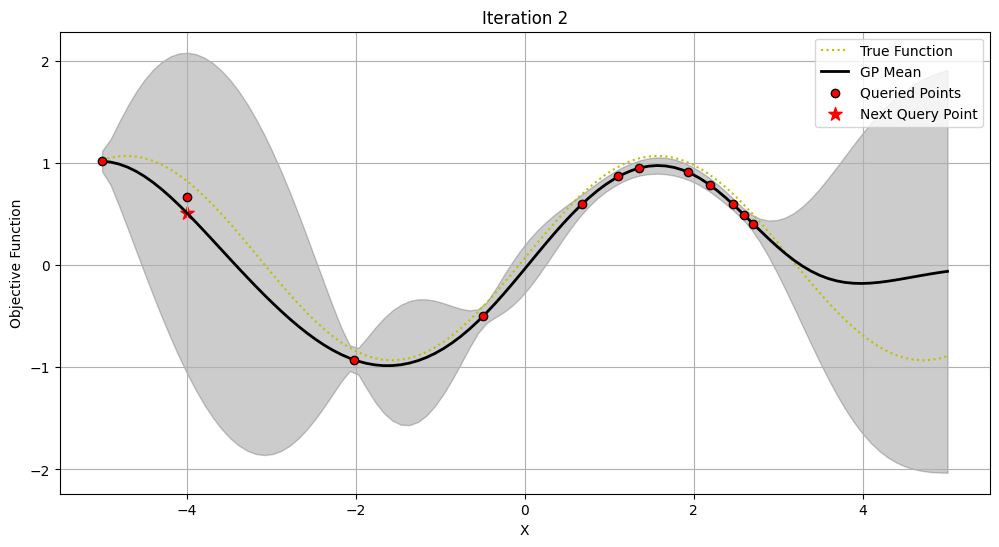

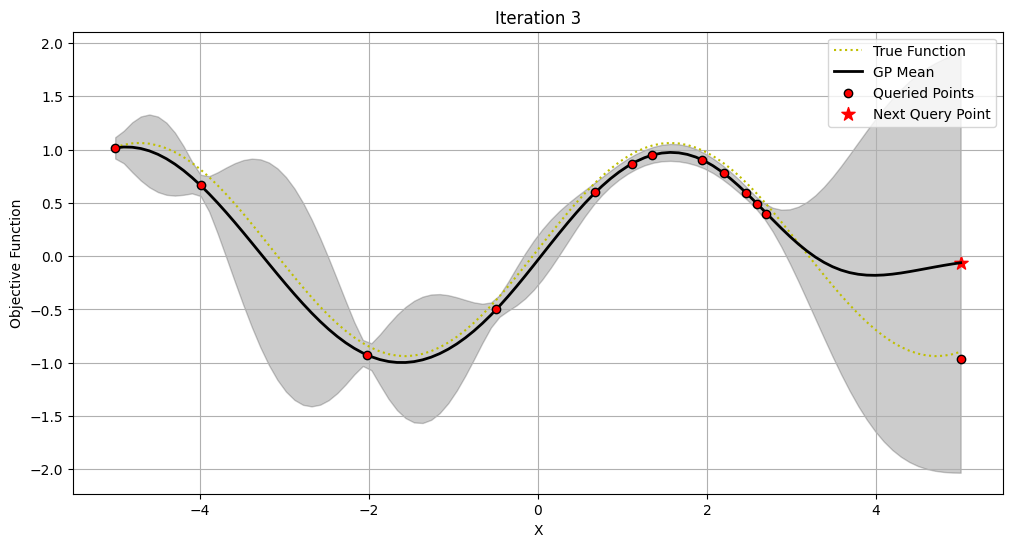

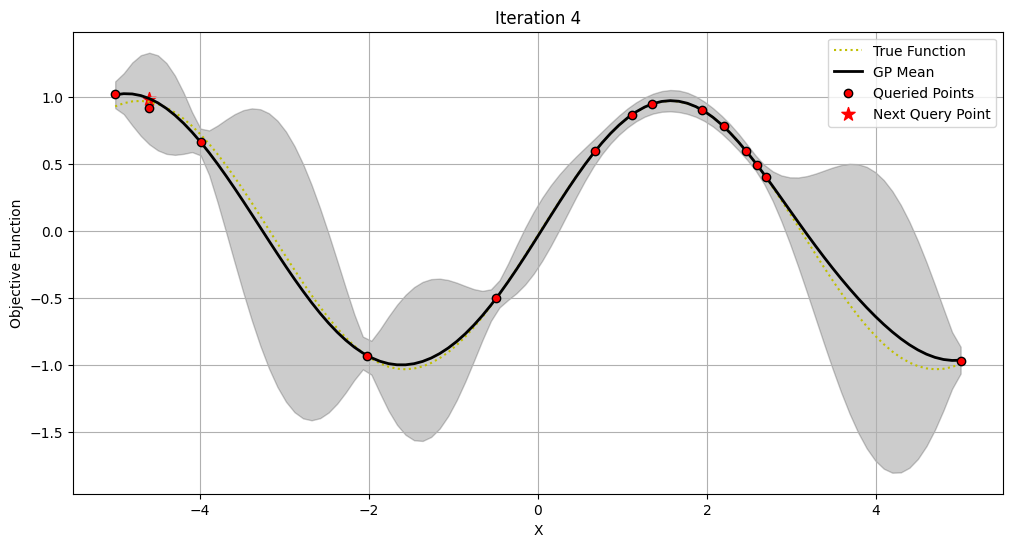

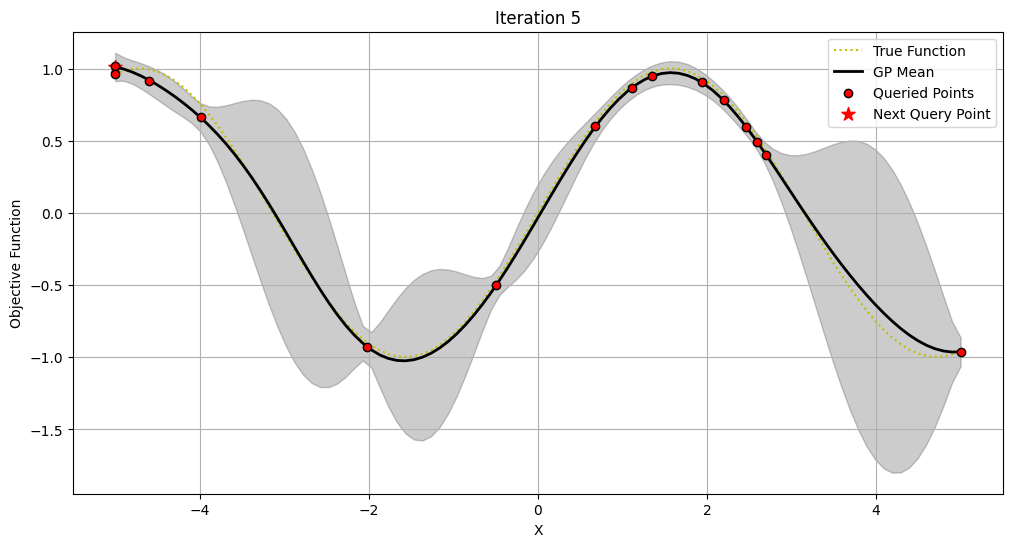

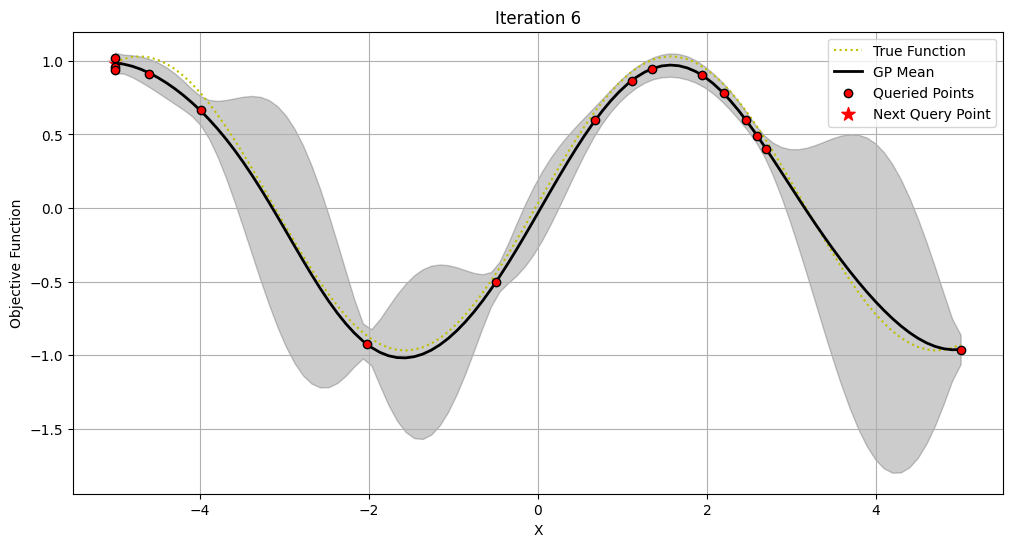

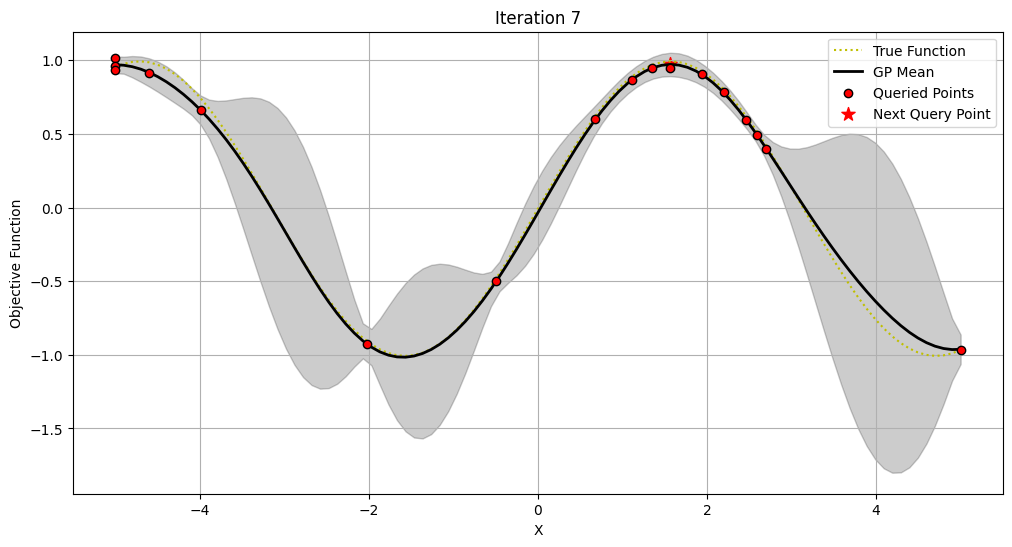

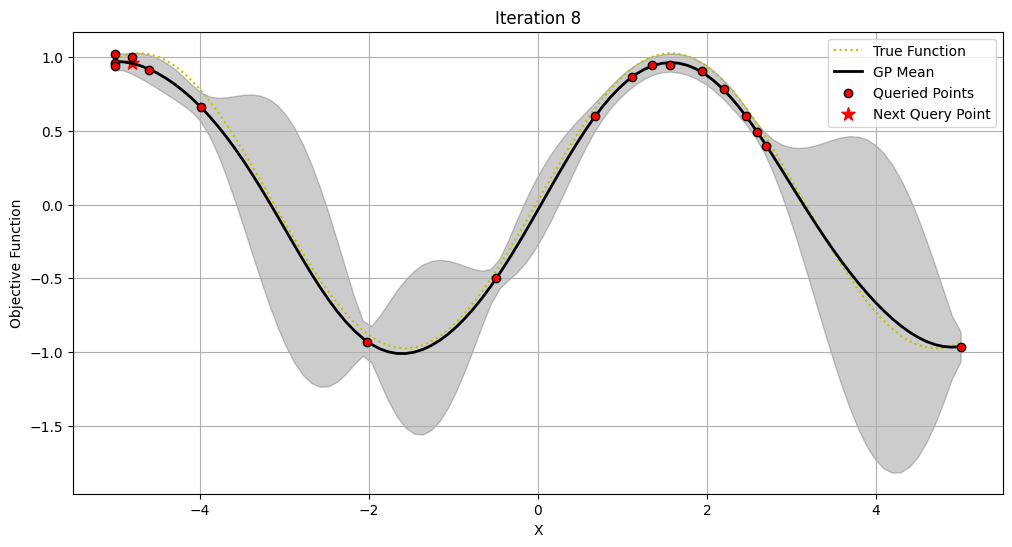

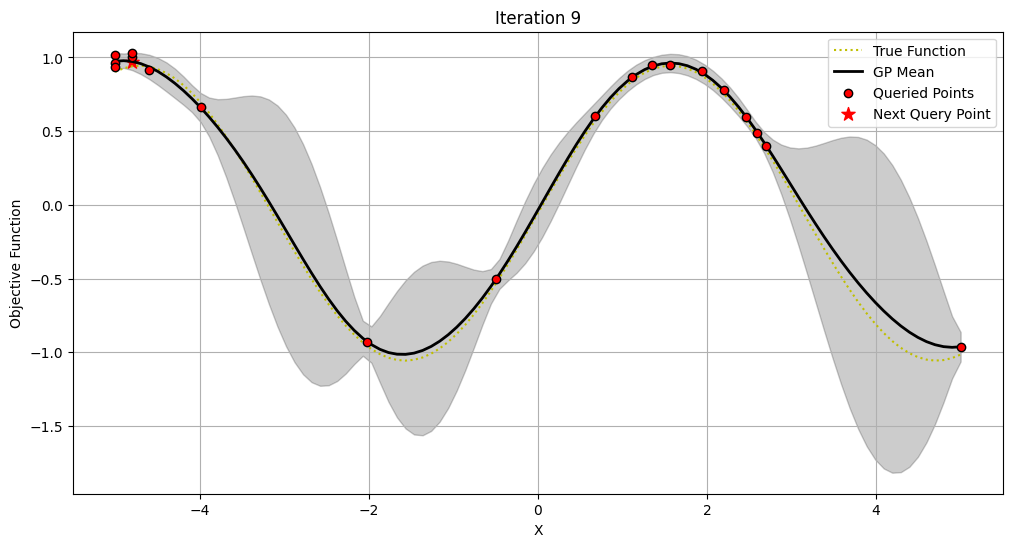

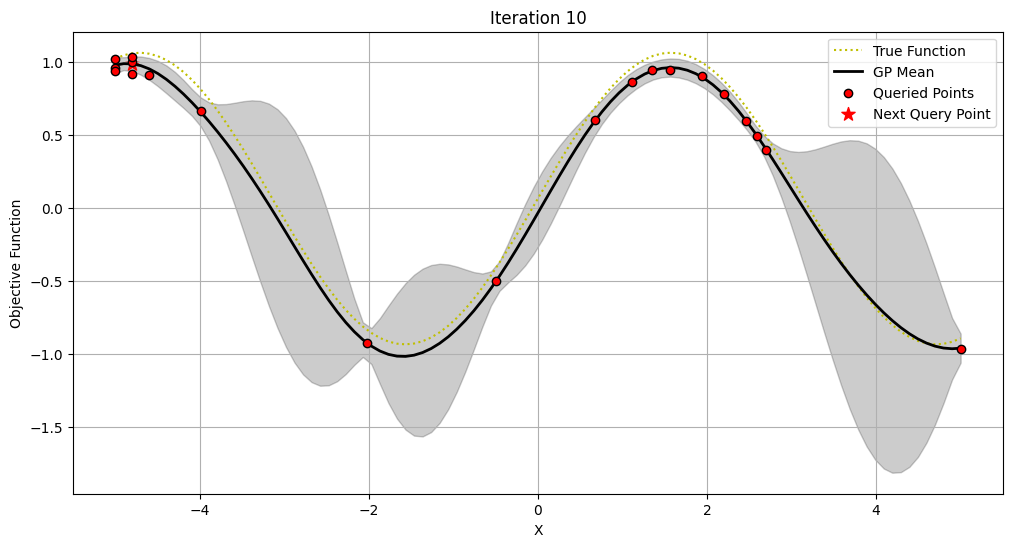

In [76]:
#Initialize kernel
T = 10
#Random initial query
X,Y, domain = initialize_query()
for i in range(T):
#   fit GP to current dataset and use regression to compute estimated mean and uncetainity
    mean, variance = posterior_update(X,Y, domain)
#   compute acquisition function
    ucb_values = upper_confidence_bound(mean, variance)
    index = np.argmax(ucb_values)
    X_new = domain[index]
    #stimulate new query
    Y_new = call_function(X_new).flatten()
    #update dataset
    X = np.vstack((X, X_new))
    Y = np.vstack((Y, Y_new))

    plt.figure(figsize=(12,6))
    plt.plot(domain, call_function(domain), 'y:', label='True Function')
    plt.plot(domain, mean, 'k', lw=2, zorder=9,label='GP Mean')
    plt.fill_between(domain.flatten(), mean.flatten() - 2 * np.sqrt(np.diag(variance)), mean.flatten() + 2 * np.sqrt(np.diag(variance)), alpha=0.2, color='k')
    plt.scatter(X, Y, c='r', zorder=10, edgecolors=(0, 0, 0), label='Queried Points')
    plt.scatter(X_new, mean[index], c='r', marker='*', s=100, label='Next Query Point')
    plt.xlabel("X")
    plt.ylabel("Objective Function")
    plt.title(f'Iteration {i+1}')
    plt.legend()
    plt.grid(True)
    plt.show()
    